### Imports & Logging Setup

In [5]:
import os
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


### Load Data & Select Features

In [6]:
import pandas as pd
import os
import logging
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load features safely
def load_all_features(file_paths, num_features=10):
    feature_sets = {}

    for key, path in file_paths.items():
        if key == "processed_data":
            continue  # Skip processed data file

        if os.path.exists(path):
            df = pd.read_csv(path)
            if key == "fold_change" and "log2_fold_change" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
            elif key == "chi_squared" and "Score" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Score")["Feature"])
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
            elif key == "lasso" and "Coefficient" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Coefficient")["Feature"])
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    # Merge selected features (remove duplicates)
    combined_features = set().union(*feature_sets.values())
    logging.info(f"Total unique features selected: {len(combined_features)}")

    return list(combined_features)

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Create a binary diagnosis column
processed_data["diagnosis"] = processed_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Select top features
num_features_to_select = 10
top_features = load_all_features(file_paths, num_features=num_features_to_select)

# Define target columns
target_column_diagnosis = "diagnosis"
target_column_stage = "stage"
target_column_subtype = "subtype"

2025-02-09 08:00:14,383 - INFO - Total unique features selected: 38


### Process Features & Labels for Multi-Output Classification

In [7]:
def process_features_and_labels(processed_data, selected_features):
    """
    Filters processed data for selected features and extracts multi-output target labels.
    
    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.

    Returns:
        tuple: Processed feature dataframe (X) and label dataframe (y).
    """
    # Check for missing features
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"{len(missing_features)} features missing from dataset! Missing: {missing_features}")

    # Stop if more than 50% of features are missing
    missing_ratio = len(missing_features) / len(selected_features)
    if missing_ratio > 0.5:
        raise ValueError(f"More than 50% of selected features are missing! ({missing_ratio * 100:.2f}%)")

    # Keep only available features
    selected_features = [f for f in selected_features if f in processed_data.columns]

    # Extract features and ensure numeric values
    X = processed_data[selected_features].apply(pd.to_numeric, errors='coerce')

    # Extract labels
    y = processed_data[["diagnosis", "stage", "subtype"]]

    # Check for missing values
    if X.isnull().values.any() or y.isnull().values.any():
        logging.warning("Missing values detected in features or labels.")

        # Print summary of missing values
        print("\n Missing values per feature (Top 5):")
        missing_counts = X.isnull().sum()
        print(missing_counts[missing_counts > 0].head())

        print("\n Missing values in labels:")
        print(y.isnull().sum())

        # Drop rows with missing values
        valid_indices = ~(X.isnull().any(axis=1) | y.isnull().any(axis=1))
        X = X[valid_indices]
        y = y[valid_indices]

    # Standardize feature values
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    logging.info("Features have been standardized.")

    # Train-Test Split (No SMOTE, just stratified sampling)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y["diagnosis"])

    # Log dataset details
    logging.info(f"Training Set Shape: {X_train.shape}")
    logging.info(f"Test Set Shape: {X_test.shape}")
    logging.info(f"Class distribution in training set:\n{y_train['diagnosis'].value_counts(normalize=True)}")

    return X_train, X_test, y_train, y_test

# Process features and labels
X_train, X_test, y_train, y_test = process_features_and_labels(processed_data, top_features)

# Debugging: Check the prepared data
print("\nExpression values sample:")
print(X_train.head())

print("\nFeature statistics:")
print(X_train.describe())

print("\nClass proportions in train set:")
print(y_train["diagnosis"].value_counts(normalize=True))

2025-02-09 08:00:16,405 - INFO - Features have been standardized.
2025-02-09 08:00:16,408 - INFO - Training Set Shape: (872, 38)
2025-02-09 08:00:16,408 - INFO - Test Set Shape: (219, 38)
2025-02-09 08:00:16,409 - INFO - Class distribution in training set:
diagnosis
1    0.989679
0    0.010321
Name: proportion, dtype: float64



Expression values sample:
     hsa-mir-518f  hsa-mir-8066  hsa-mir-523  hsa-mir-1825  hsa-mir-1283-2  \
459     -0.045815     -0.055165    -0.055121      -0.11619       -0.067550   
765     -0.049625     -0.055165    -0.055121      -0.11619       -0.055086   
749     -0.049625     -0.055165    -0.055121      -0.11619       -0.067550   
990     -0.049625     -0.055165    -0.055121      -0.11619       -0.067550   
270     -0.048826     -0.055165    -0.055121      -0.11619       -0.048564   

     hsa-mir-571  hsa-mir-520d  hsa-mir-6766  hsa-mir-1253  hsa-mir-4731  ...  \
459    -0.059853     -0.059336     -0.388206     -0.042615     -0.281918  ...   
765    -0.059853     -0.059336     -0.388206     -0.042615     -0.281918  ...   
749    -0.059853     -0.059336     -0.388206     -0.042615     -0.281918  ...   
990    -0.059853     -0.059336     -0.388206     -0.042615     -0.281918  ...   
270    -0.059853     -0.059336      0.159763     -0.042615     -0.281918  ...   

     hsa-mir-526a

### Train-Test Split & Feature Scaling

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Extract labels
y = processed_data[["diagnosis", "stage", "subtype"]]

# Ensure y is a DataFrame
if isinstance(y, pd.Series):
    y = y.to_frame()

# Debugging: Print Columns to Verify
print("Columns in filtered_data:", filtered_data.columns)
print("Columns in y:", y.columns)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log Split Information
print("\nTrain-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

Columns in filtered_data: Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-9500', 'hsa-mir-96', 'hsa-mir-98',
       'hsa-mir-99a', 'hsa-mir-99b', 'stage', 'subtype', 'diagnosis'],
      dtype='object', length=1884)
Columns in y: Index(['diagnosis', 'stage', 'subtype'], dtype='object')

Train-Test Split Information:
Training set: (866, 38), Testing set: (217, 38)

Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Training set class distribution (Stage):
stage
1    453
2    246
3    139
4     19
0      9
Name: count, dtype: int64

Training set class distribution (Subtype):
subtype
1    448
2    409
0      9
Name: count, dtype: int64

Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Testing set class distribution (

### Train Multi-Output SVM Model

In [ ]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Train SVM Models for Diagnosis, Stage, and Subtype
models = {}
best_estimators = {}
y_preds = {}

for label, y_train, y_test in zip(
    ["Diagnosis", "Stage", "Subtype"],
    [y_train_diagnosis, y_train_stage, y_train_subtype],
    [y_test_diagnosis, y_test_stage, y_test_subtype]
):
    print(f"\nTraining {label} SVM...")
    
    # Define & train model with GridSearchCV
    svm = SVC(class_weight="balanced", random_state=42)
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store best model & predictions
    best_estimators[label] = grid_search.best_estimator_
    y_preds[label] = best_estimators[label].predict(X_test)

    # Print best hyperparameters & classification report
    print(f"\nBest SVM Hyperparameters ({label}): {grid_search.best_params_}")
    print(f"\nClassification Report for {label}:\n",
          classification_report(y_test, y_preds[label], zero_division=0))

# Store predictions separately
y_pred_diagnosis = y_preds["Diagnosis"]
y_pred_stage = y_preds["Stage"]
y_pred_subtype = y_preds["Subtype"]



Training Diagnosis SVM...

Best SVM Hyperparameters (Diagnosis): {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       215

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217


Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.94      1.00      0.97       113
           2       1.00      0.94      0.97        62
           3       0.94      0.94      0.94        35
           4       1.00      0.40      0.57         5

    accuracy                           0.96       217
   mac

### Evaluate Multi-Output Model


-------------------- SVM_Diagnosis Results --------------------

Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       215

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217


Confusion Matrix:
 [[  2   0]
 [  0 215]]

Confusion matrix saved to ../results/svm/svm_diagnosis_confusion_matrix.png


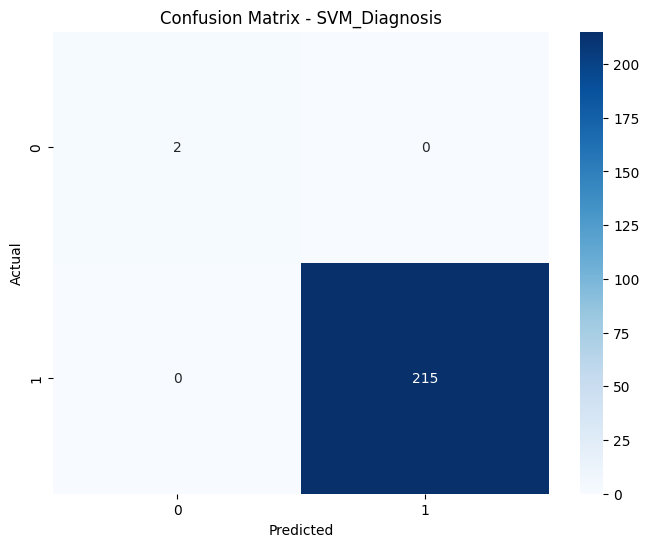

2025-02-09 10:25:58,102 - INFO - 
Model Evaluation Completed for SVM_Diagnosis!
2025-02-09 10:25:58,102 - INFO - Accuracy: 1.0000
2025-02-09 10:25:58,103 - INFO - Confusion Matrix: [[2, 0], [0, 215]]



-------------------- SVM_Stage Results --------------------

Accuracy: 0.9585

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.94      1.00      0.97       113
           2       1.00      0.94      0.97        62
           3       0.94      0.94      0.94        35
           4       1.00      0.40      0.57         5

    accuracy                           0.96       217
   macro avg       0.98      0.86      0.89       217
weighted avg       0.96      0.96      0.96       217


Confusion Matrix:
 [[  2   0   0   0   0]
 [  0 113   0   0   0]
 [  0   2  58   2   0]
 [  0   2   0  33   0]
 [  0   3   0   0   2]]

Confusion matrix saved to ../results/svm/svm_stage_confusion_matrix.png


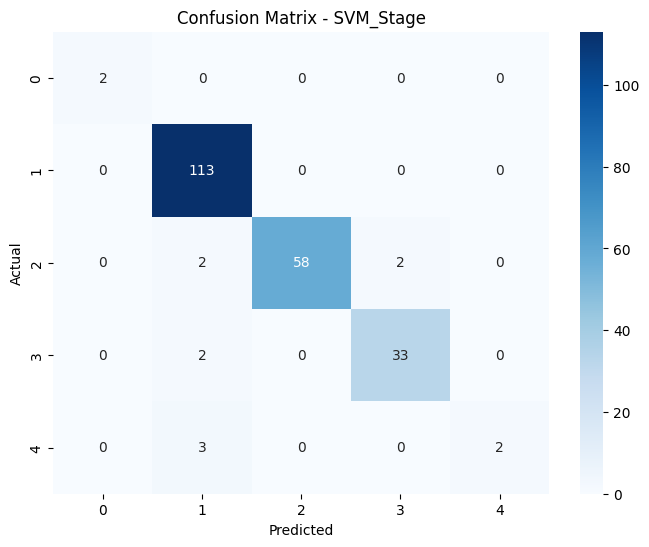

2025-02-09 10:25:58,312 - INFO - 
Model Evaluation Completed for SVM_Stage!
2025-02-09 10:25:58,313 - INFO - Accuracy: 0.9585
2025-02-09 10:25:58,313 - INFO - Confusion Matrix: [[2, 0, 0, 0, 0], [0, 113, 0, 0, 0], [0, 2, 58, 2, 0], [0, 2, 0, 33, 0], [0, 3, 0, 0, 2]]



-------------------- SVM_Subtype Results --------------------

Accuracy: 0.9816

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.99      0.97      0.98       112
           2       0.97      0.99      0.98       103

    accuracy                           0.98       217
   macro avg       0.99      0.99      0.99       217
weighted avg       0.98      0.98      0.98       217


Confusion Matrix:
 [[  2   0   0]
 [  0 109   3]
 [  0   1 102]]

Confusion matrix saved to ../results/svm/svm_subtype_confusion_matrix.png


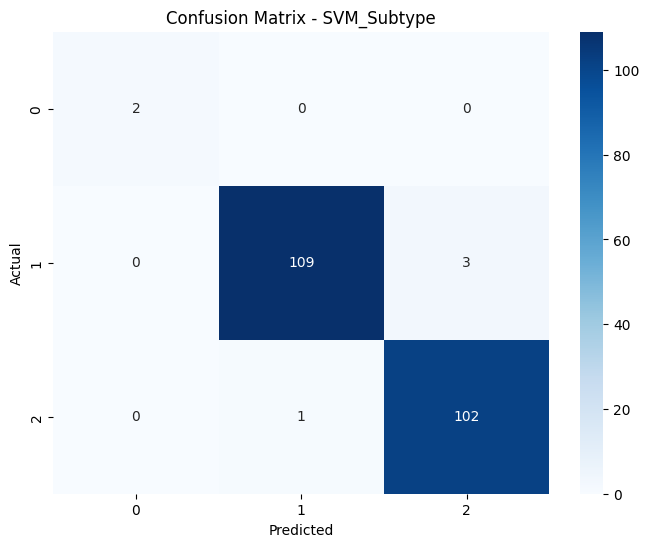

2025-02-09 10:25:58,483 - INFO - 
Model Evaluation Completed for SVM_Subtype!
2025-02-09 10:25:58,484 - INFO - Accuracy: 0.9816
2025-02-09 10:25:58,485 - INFO - Confusion Matrix: [[2, 0, 0], [0, 109, 3], [0, 1, 102]]


In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging

# Logging Setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_model(y_test, y_pred, model_name, save_dir="../results/svm/"):
    """
    Evaluate model performance with accuracy, classification reports, and confusion matrices.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Compute Metrics
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')

    # Save Plot
    cm_path = os.path.join(save_dir, f"{model_name.lower()}_confusion_matrix.png")
    plt.savefig(cm_path)
    print(f"\nConfusion matrix saved to {cm_path}")
    plt.show()

    # Log Evaluation Metrics
    logging.info(f"\nModel Evaluation Completed for {model_name}!")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Confusion Matrix: {cm.tolist()}")

    return {
        "accuracy": accuracy,
        "confusion_matrix": cm.tolist(),
        "classification_report": report
    }

# ✅ Evaluate Each Model
metrics_diagnosis = evaluate_model(y_test_diagnosis, y_pred_diagnosis, model_name="SVM_Diagnosis")
metrics_stage = evaluate_model(y_test_stage, y_pred_stage, model_name="SVM_Stage")
metrics_subtype = evaluate_model(y_test_subtype, y_pred_subtype, model_name="SVM_Subtype")

### Visualize Performance Metrics


Classification Report for Precision, Recall, F1-score - Diagnosis Classification:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       215

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217

Metrics comparison saved to ../results/svm/plots/diagnosis_metrics_comparison.png


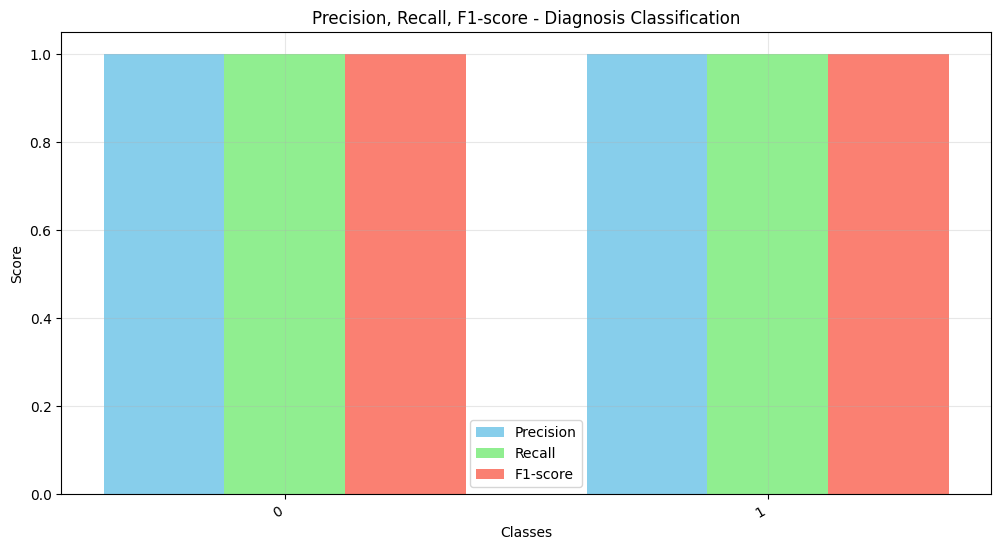


Classification Report for Precision, Recall, F1-score - Stage Classification:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.94      1.00      0.97       113
           2       1.00      0.94      0.97        62
           3       0.94      0.94      0.94        35
           4       1.00      0.40      0.57         5

    accuracy                           0.96       217
   macro avg       0.98      0.86      0.89       217
weighted avg       0.96      0.96      0.96       217

Metrics comparison saved to ../results/svm/plots/stage_metrics_comparison.png


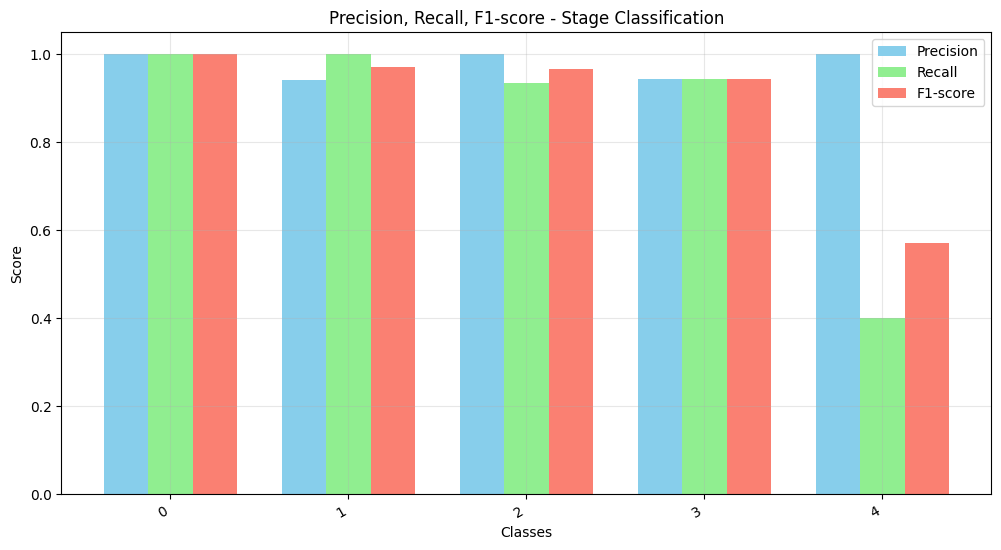


Classification Report for Precision, Recall, F1-score - Subtype Classification:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.99      0.97      0.98       112
           2       0.97      0.99      0.98       103

    accuracy                           0.98       217
   macro avg       0.99      0.99      0.99       217
weighted avg       0.98      0.98      0.98       217

Metrics comparison saved to ../results/svm/plots/subtype_metrics_comparison.png


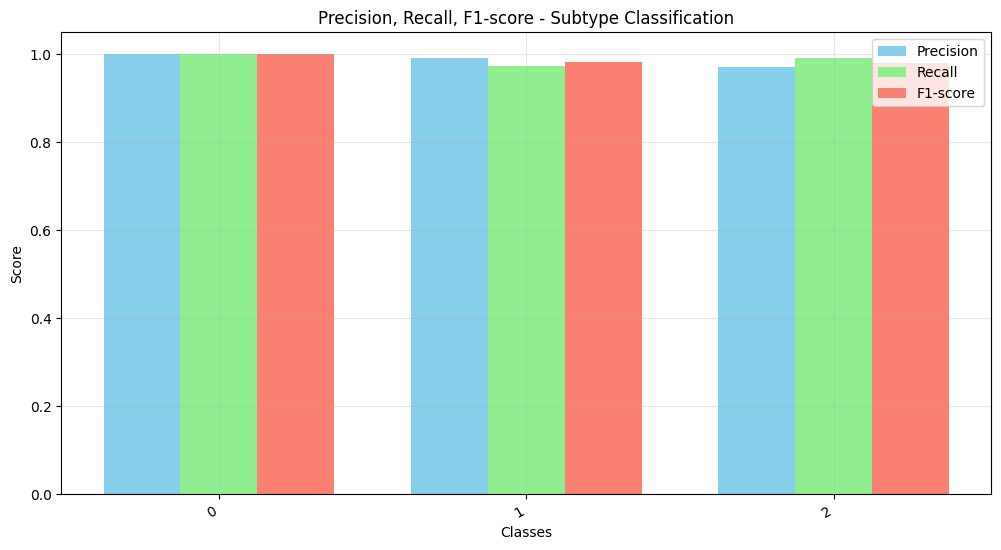

In [39]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define Save Directory
save_dir = "../results/svm/plots/"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

def plot_metrics_comparison(y_true, y_pred, labels, title, save_path=None):
    """Plots precision, recall, and F1-score for each class and prints the classification report."""
    report = classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels], output_dict=True)

    # Print Classification Report Once
    print(f"\nClassification Report for {title}:\n")
    print(classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in labels]))

    # Extract Metrics
    metrics_data = {'Precision': [], 'Recall': [], 'F1-score': []}
    for label in labels:
        label_str = str(label)
        if label_str in report:
            metrics_data['Precision'].append(report[label_str]['precision'])
            metrics_data['Recall'].append(report[label_str]['recall'])
            metrics_data['F1-score'].append(report[label_str]['f1-score'])
    
    # Plot Metrics
    plt.figure(figsize=(12, 6))
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, metrics_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, metrics_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, metrics_data['F1-score'], width, label='F1-score', color='salmon')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, labels, rotation=30, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save & Show Plot
    if save_path:
        plt.savefig(save_path)
        print(f"Metrics comparison saved to {save_path}")
    plt.show()

# ✅ Visualize Performance for Each Model
diagnosis_labels = np.unique(y_test_diagnosis)
plot_metrics_comparison(y_test_diagnosis, y_pred_diagnosis, diagnosis_labels, 
                        "Precision, Recall, F1-score - Diagnosis Classification", 
                        save_path=os.path.join(save_dir, "diagnosis_metrics_comparison.png"))

stage_labels = np.unique(y_test_stage)
plot_metrics_comparison(y_test_stage, y_pred_stage, stage_labels, 
                        "Precision, Recall, F1-score - Stage Classification", 
                        save_path=os.path.join(save_dir, "stage_metrics_comparison.png"))

subtype_labels = np.unique(y_test_subtype)
plot_metrics_comparison(y_test_subtype, y_pred_subtype, subtype_labels, 
                        "Precision, Recall, F1-score - Subtype Classification", 
                        save_path=os.path.join(save_dir, "subtype_metrics_comparison.png"))

### Save Everything & Finalize the Pipeline

In [41]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save Predictions & Actual Labels
predictions = {
    "Diagnosis": (y_test_diagnosis, y_pred_diagnosis, "svm_predictions_diagnosis.csv"),
    "Stage": (y_test_stage, y_pred_stage, "svm_predictions_stage.csv"),
    "Subtype": (y_test_subtype, y_pred_subtype, "svm_predictions_subtype.csv"),
}

for label, (y_test, y_pred, filename) in predictions.items():
    pred_path = os.path.join(output_dir, filename)
    pd.DataFrame({"actual": y_test, "predicted": y_pred}).to_csv(pred_path, index=False)
    logging.info(f"{label} predictions saved to {pred_path}")

# Save Experiment Metadata
metadata = {
    "diagnosis_hyperparameters": grid_diagnosis.best_params_,
    "stage_hyperparameters": grid_stage.best_params_,
    "subtype_hyperparameters": grid_subtype.best_params_,
    "diagnosis_accuracy": metrics_diagnosis["accuracy"],
    "stage_accuracy": metrics_stage["accuracy"],
    "subtype_accuracy": metrics_subtype["accuracy"],
    "train_size": X_train.shape[0],
    "test_size": X_test.shape[0],
}

metadata_path = os.path.join(output_dir, "svm_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")

# Save Trained Models
models = {
    "Diagnosis": (best_svm_diagnosis, "svm_model_diagnosis.pkl"),
    "Stage": (best_svm_stage, "svm_model_stage.pkl"),
    "Subtype": (best_svm_subtype, "svm_model_subtype.pkl"),
}

for label, (model, filename) in models.items():
    model_path = os.path.join(output_dir, filename)
    if model:
        joblib.dump(model, model_path)
        logging.info(f"{label} model saved to {model_path}")
    else:
        logging.warning(f"{label} model was not found and was not saved.")

print("\nAll results successfully saved. The SVM pipeline is complete!")


2025-02-09 10:27:28,389 - INFO - Diagnosis predictions saved to ../results/svm/svm_predictions_diagnosis.csv
2025-02-09 10:27:28,390 - INFO - Stage predictions saved to ../results/svm/svm_predictions_stage.csv
2025-02-09 10:27:28,393 - INFO - Subtype predictions saved to ../results/svm/svm_predictions_subtype.csv
2025-02-09 10:27:28,394 - INFO - Metadata saved to ../results/svm/svm_metadata.json
2025-02-09 10:27:28,397 - INFO - Diagnosis model saved to ../results/svm/svm_model_diagnosis.pkl
2025-02-09 10:27:28,399 - INFO - Stage model saved to ../results/svm/svm_model_stage.pkl
2025-02-09 10:27:28,401 - INFO - Subtype model saved to ../results/svm/svm_model_subtype.pkl



All results successfully saved. The SVM pipeline is complete!
